# Прикладная статистика в машинном обучении 2021-2022

## Домашнее задание #1

## Часть 2

---

In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.6f' % x)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Задача 14. Divide et impera!

Файле `14.csv` содержит данные, которые являются смесью гауссиан. 

**[a]** Постройте гистограмму выборки. Изучите гистограмму и сделайте предположения о количестве гауссиан, а также задайте разумный вектор начальных параметров $\theta$.

**[б]** **(3 балла)** Реализуйте EM-алгоритм для нахождения оценки $\hat{\theta}$. Итоговые формулы представьте только в виде кода (то есть не требуется отдельно прикладывать или техать вывод формул).

**[в]** Постройте график $Q$ в зависимости от числа итераций.

**[г]** Являются ли полученные оценки параметров адекватными (адекватность оцените визуально по гистограмме). Если нет, приведите возможную причину провала EM-алгоритма. 

In [ ]:
import requests
url = 'https://raw.githubusercontent.com/V-Marco/psmo_21_22/main/hw/hw1/14.csv'
res = requests.get(url, allow_redirects=True)
with open('14.csv','wb') as file:
    file.write(res.content)
df14 = pd.read_csv('14.csv', usecols=[1])
df14

,X
0,25.000141
1,2.996731
2,-0.673019
3,2.998876
4,25.000178
...,...
13995,3.954072
13996,3.002716
13997,6.085865
13998,2.983889


##### (а) Постройте гистограмму выборки. Изучите гистограмму и сделайте предположения о количестве гауссиан, а также задайте разумный вектор начальных параметров $\theta$.

In [ ]:
df14.X.describe()

count   14000.000000
mean       11.850371
std        10.594174
min        -1.900689
25%         2.997009
50%         5.371589
75%        24.999488
max        26.935204
Name: X, dtype: float64

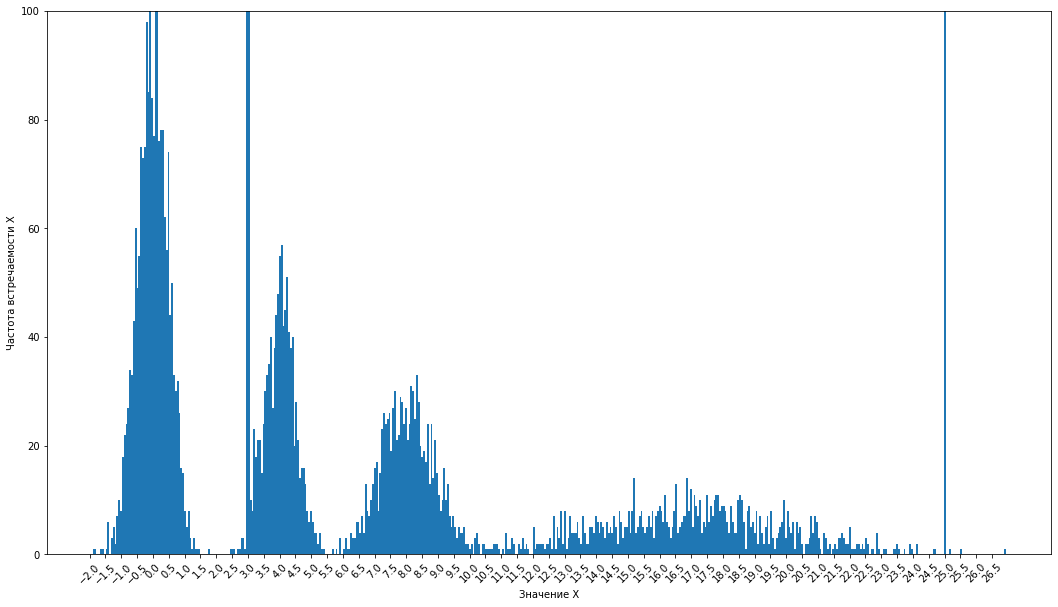

In [ ]:
plt.figure(figsize=(18, 10))
plt.hist(df14.X, bins=500)
plt.xticks(np.arange(-2, 27, 0.5), rotation=45)
plt.xlabel("Значение Х")
plt.ylabel("Частота встречаемости Х")
plt.ylim(0, 100)
plt.show()

На приведённом графике отчётливо видно, что выборка состоит из 4 полноценных гауссиан с увеличивающейся по мере увеличения мат ожидания дисперсией. Однако также отчётливо видно два вырожденных распределения, для которых, вероятно, также нужно выделить 2 гауссианы с около-нулевой дисперсией.

$$X_1 \sim N(0, sigma), -2<X<2$$
$$X_2 \sim N(4, sigma*1.5), 2<X<5.5$$
$$X_3 \sim N(3, sigma*0.2), 2.9<X<3.1$$
$$X_4 \sim N(8, sigma*2), 5.5<X<10$$
$$X_5 \sim N(17, sigma*4), 10<X<27$$
$$X_6 \sim N(25, sigma*0.1), 24.8<X<25.2$$

Зададим следующий вектор начальных параметров:

In [ ]:
sigma2_1 = df14.X.loc[df14.X<2].var()
p_1 = len(df14.X.loc[df14.X<2])/len(df14)*0.7
sigma2_2 = df14.X.loc[(df14.X>2) & (df14.X<6)].var()
p_2 = len(df14.X.loc[(df14.X>2) & (df14.X<6)])/len(df14)*0.7
sigma2_3 = df14.X.loc[(df14.X>2.9) & (df14.X<3.1)].var()
p_3 = len(df14.X.loc[(df14.X>2.9) & (df14.X<3.1)])/len(df14)*0.7
sigma2_4 = df14.X.loc[(df14.X>5) & (df14.X<10)].var()
p_4 = len(df14.X.loc[(df14.X>5) & (df14.X<10)])/len(df14)*0.7
sigma2_5 = df14.X.loc[(df14.X>9) & (df14.X<27)].var()
p_5 = len(df14.X.loc[(df14.X>9) & (df14.X<27)])/len(df14)*0.7
sigma2_6 = df14.X.loc[(df14.X>24.8) & (df14.X<25.2)].var()
p_6 = 1-p_1-p_2-p_3-p_4-p_5

In [ ]:
# theta = (mu_1, sigma2_1, p_1, 
#          mu2, sigma2_2, p_2,
#          mu_3, sigma2_3, p_3,
#          mu_4, sigma2_4, p_4, 
#          mu_5, sigma2_5)
# (воспользовались эвристикой)
theta = np.array([0, sigma2_1, p_1,
                 4, sigma2_2, p_2,
                 3, sigma2_3, p_3,
                 8, sigma2_4, p_4,
                 17, sigma2_5, p_5,
                 25, sigma2_6, p_6])
print(len(theta))
theta

18


array([0.00000000e+00, 2.39871971e-01, 1.42842226e-01, 4.00000000e+00,
       2.52804116e-01, 7.24542763e-02, 3.00000000e+00, 9.79035520e-05,
       2.84629402e-01, 8.00000000e+00, 5.93996382e-01, 6.25285509e-02,
       1.70000000e+01, 1.52939039e+01, 8.04902599e-02, 2.50000000e+01,
       1.01464637e-06, 3.57055284e-01])

##### (б) Реализуйте EM-алгоритм для нахождения оценки $\hat{\theta}$. Итоговые формулы представьте только в виде кода (то есть не требуется отдельно прикладывать или техать вывод формул).

In [ ]:
# Задайте плотность x
def f(x, mu, sigma2):
    return 1 / np.sqrt(2 * np.pi * sigma2) * np.exp(-1/2 * 1/sigma2 * (x - mu)**2)

x = df14.X

In [ ]:
p_z_1 = f(x, mu = theta[0], sigma2 = theta[1]) * theta[2] / \
              (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
              (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
              (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
              (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
              (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
              (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

p_z_2 = (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) / \
            (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
            (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
            (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
            (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
            (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
            (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

p_z_3 = (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7])/ \
            (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
            (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
            (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
            (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
            (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
            (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

p_z_4 = (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) / \
            (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
            (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
            (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
            (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
            (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
            (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

p_z_5 = (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) / \
            (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
            (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
            (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
            (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
            (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
            (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

p_z_6 = (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]) / \
            (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
            (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
            (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
            (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
            (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
            (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

In [ ]:
# Рассчитайте распределение латентных переменных на наших данных
def calc_distribution(x, theta):
  # p(z=j) =  f(x | theta, z=1 ) * p(z=1) / sum [f(x | theta, z=j ) * p(z=j)]
  p_z_1 = f(x, mu = theta[0], sigma2 = theta[1]) * theta[2] / \
              (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
              (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
              (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
              (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
              (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
              (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

  p_z_2 = (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) / \
              (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
              (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
              (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
              (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
              (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
              (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

  p_z_3 = (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7])/ \
              (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
              (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
              (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
              (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
              (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
              (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

  p_z_4 = (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) / \
              (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
              (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
              (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
              (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
              (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
              (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

  p_z_5 = (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) / \
              (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
              (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
              (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
              (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
              (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
              (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

  p_z_6 = (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]) / \
              (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
              (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
              (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
              (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
              (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
              (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))
  return pd.concat([p_z_1, p_z_2, p_z_3, p_z_4, p_z_5, p_z_6], axis=1, keys=['z1', 'z2', 'z3', 'z4', 'z5', 'z6'])

pd.concat([x, calc_distribution(x, theta)], axis=1)

,X,z1,z2,z3,z4,z5,z6
0,25.000141,0.000000,0.000000,0.000000,0.000000,0.000223,0.999777
1,2.996731,0.000000,0.002934,0.997062,0.000000,0.000004,0.000000
2,-0.673019,0.999983,0.000000,0.000000,0.000000,0.000017,0.000000
3,2.998876,0.000000,0.002843,0.997153,0.000000,0.000004,0.000000
4,25.000178,0.000000,0.000000,0.000000,0.000000,0.000223,0.999777
...,...,...,...,...,...,...,...
13995,3.954072,0.000000,0.999619,0.000000,0.000005,0.000377,0.000000
13996,3.002716,0.000000,0.002972,0.997024,0.000000,0.000004,0.000000
13997,6.085865,0.000000,0.003355,0.000000,0.828018,0.168627,0.000000
13998,2.983889,0.000000,0.008247,0.991739,0.000000,0.000013,0.000000


In [ ]:
# Реализуйте формулы для одного M-шага
mu_1 = np.sum(p_z_1 * x) / np.sum(p_z_1)
mu_2 = np.sum(p_z_2 * x) / np.sum(p_z_2)
mu_3 = np.sum(p_z_3 * x) / np.sum(p_z_3)
mu_4 = np.sum(p_z_4 * x) / np.sum(p_z_4)
mu_5 = np.sum(p_z_5 * x) / np.sum(p_z_5)
mu_6 = np.sum(p_z_6 * x) / np.sum(p_z_6)
sigma2_1 = np.sum((x - mu_1) ** 2 * p_z_1)/ np.sum(p_z_1)
sigma2_2 = np.sum((x - mu_2) ** 2 * p_z_2)/ np.sum(p_z_2)
sigma2_3 = np.sum((x - mu_3) ** 2 * p_z_3)/ np.sum(p_z_3)
sigma2_4 = np.sum((x - mu_4) ** 2 * p_z_4)/ np.sum(p_z_4)
sigma2_5 = np.sum((x - mu_5) ** 2 * p_z_5)/ np.sum(p_z_5)
sigma2_6 = np.sum((x - mu_6) ** 2 * p_z_6)/ np.sum(p_z_6)
p_1 = np.sum(p_z_1) / len(x)
p_2 = np.sum(p_z_2) / len(x)
p_3 = np.sum(p_z_3) / len(x)
p_4 = np.sum(p_z_4) / len(x)
p_5 = np.sum(p_z_5) / len(x)
p_6 = np.sum(p_z_6) / len(x)
theta_new = np.array([mu_1, sigma2_1, p_1,
                 mu_2, sigma2_2, p_2,
                 mu_3, sigma2_3, p_3,
                 mu_4, sigma2_4, p_4,
                 mu_5, sigma2_5, p_5,
                 mu_6, sigma2_6, p_6])
theta

array([0.00000000e+00, 2.40183562e-01, 1.00000000e-01, 4.00000000e+00,
       2.17433134e-01, 2.50300000e-01, 3.00000000e+00, 1.13278384e-04,
       2.01100000e-01, 8.00000000e+00, 8.14939275e-01, 5.11500000e-02,
       1.70000000e+01, 1.41837542e+01, 3.05800000e-01, 2.50000000e+01,
       5.74932320e-06, 9.16500000e-02])

In [ ]:
theta_new

array([-7.91472387e-03,  2.39871971e-01,  1.42842226e-01,  3.99046412e+00,
        2.52804116e-01,  7.24542763e-02,  3.00032231e+00,  9.79035520e-05,
        2.84629402e-01,  7.95040463e+00,  5.93996382e-01,  6.25285509e-02,
        1.59631084e+01,  1.52939039e+01,  8.04902599e-02,  2.50000303e+01,
        1.01464637e-06,  3.57055284e-01])

In [ ]:
# Логарифм функции плотности x
def lnf(x, mu, sigma2):
    return -1/2 * np.log(2 * np.pi * sigma2) - 1/2 * (x - mu) ** 2 / sigma2

In [ ]:
def Q_f(x, theta, p_z_1, p_z_2, p_z_3, p_z_4, p_z_5, p_z_6):
    ell1 = lnf(x, theta[0], theta[1]) + np.log(theta[2])
    ell2 = lnf(x, theta[3], theta[4]) + np.log(theta[5])
    ell3 = lnf(x, theta[6], theta[7]) + np.log(theta[8])
    ell4 = lnf(x, theta[9], theta[10]) + np.log(theta[11])
    ell5 = lnf(x, theta[12], theta[13]) + np.log(theta[14])
    ell6 = lnf(x, theta[15], theta[16]) + np.log(theta[17])
    return np.sum(p_z_1 * ell1 + p_z_2 * ell2 + p_z_3 * ell3 +\
                 p_z_4 * ell4 + p_z_5 * ell5 + p_z_6 * ell6)

In [ ]:
def EM(x, theta, n=100, eps=1e-4):
    
    Q_history = []
    
    for i in range(n):
        
        # E-step
        p_z_1 = f(x, mu = theta[0], sigma2 = theta[1]) * theta[2] / \
            (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
             (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
             (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
             (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
             (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
             (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

        p_z_2 = (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) / \
                    (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
                     (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
                     (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
                     (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
                     (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
                     (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

        p_z_3 = (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7])/ \
                    (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
                     (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
                     (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
                     (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
                     (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
                     (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

        p_z_4 = (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) / \
                    (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
                     (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
                     (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
                     (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
                     (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
                     (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

        p_z_5 = (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) / \
                    (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
                     (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
                     (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
                     (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
                     (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
                     (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))

        p_z_6 = (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]) / \
                    (theta[2] * f(x, mu = theta[0], sigma2 = theta[1]) + \
                     (theta[5]) * f(x, mu = theta[3], sigma2 = theta[4]) + \
                     (theta[8]) * f(x, mu = theta[6], sigma2 = theta[7]) + \
                     (theta[11]) * f(x, mu = theta[9], sigma2 = theta[10]) + \
                     (theta[14]) * f(x, mu = theta[12], sigma2 = theta[13]) + \
                     (theta[17]) * f(x, mu = theta[15], sigma2 = theta[16]))
        
        Q_history.append(Q_f(x, theta, p_z_1, p_z_2, p_z_3, p_z_4, p_z_5, p_z_6))
        
        if i > 0:
            if (Q_history[i] - Q_history[i-1])**2 < eps:
              print('delta Q < eps on', i, '!!!')
              break
        
        # M-step
        mu_1 = np.sum(p_z_1 * x) / np.sum(p_z_1)
        mu_2 = np.sum(p_z_2 * x) / np.sum(p_z_2)
        mu_3 = np.sum(p_z_3 * x) / np.sum(p_z_3)
        mu_4 = np.sum(p_z_4 * x) / np.sum(p_z_4)
        mu_5 = np.sum(p_z_5 * x) / np.sum(p_z_5)
        mu_6 = np.sum(p_z_6 * x) / np.sum(p_z_6)
        sigma2_1 = np.sum((x - mu_1) ** 2 * p_z_1)/ np.sum(p_z_1)
        sigma2_2 = np.sum((x - mu_2) ** 2 * p_z_2)/ np.sum(p_z_2)
        sigma2_3 = np.sum((x - mu_3) ** 2 * p_z_3)/ np.sum(p_z_3)
        sigma2_4 = np.sum((x - mu_4) ** 2 * p_z_4)/ np.sum(p_z_4)
        sigma2_5 = np.sum((x - mu_5) ** 2 * p_z_5)/ np.sum(p_z_5)
        sigma2_6 = np.sum((x - mu_6) ** 2 * p_z_6)/ np.sum(p_z_6)
        p_1 = np.sum(p_z_1) / len(x)
        p_2 = np.sum(p_z_2) / len(x)
        p_3 = np.sum(p_z_3) / len(x)
        p_4 = np.sum(p_z_4) / len(x)
        p_5 = np.sum(p_z_5) / len(x)
        p_6 = np.sum(p_z_6) / len(x)
        theta_new = np.array([mu_1, sigma2_1, p_1,
                         mu_2, sigma2_2, p_2,
                         mu_3, sigma2_3, p_3,
                         mu_4, sigma2_4, p_4,
                         mu_5, sigma2_5, p_5,
                         mu_6, sigma2_6, p_6])
        
        theta = theta_new
    
    return (theta, Q_history)

In [ ]:
theta = np.array([-1, sigma2_1*1000, p_1,
                 5, sigma2_2*100, p_2,
                 6, sigma2_3*100, p_3,
                 8, sigma2_4*10, p_4,
                 21, sigma2_5*10, p_5,
                 25, sigma2_6*10, p_6])
print(len(theta))
theta

18


array([-1.00000000e+00,  2.39871971e+02,  1.42842226e-01,  5.00000000e+00,
        2.52804116e+01,  7.24542763e-02,  6.00000000e+00,  9.79035520e-03,
        2.84629402e-01,  8.00000000e+00,  5.93996382e+00,  6.25285509e-02,
        2.10000000e+01,  1.52939039e+02,  8.04902599e-02,  2.50000000e+01,
        1.01464637e-05,  3.57055284e-01])

In [ ]:
theta, Q = EM(x, theta)
theta

delta Q < eps on 13 !!!


array([-7.80466575e-03,  2.40046639e-01,  1.42856229e-01,  4.00864066e+00,
        2.40027164e-01,  7.12548478e-02,  3.00033350e+00,  9.87252114e-05,
        2.85908528e-01,  8.02341063e+00,  6.90405886e-01,  7.14163094e-02,
        1.68921887e+01,  9.08577271e+00,  7.14232071e-02,  2.50000303e+01,
        1.01467845e-06,  3.57140878e-01])

##### (в) Постройте график $Q$ в зависимости от числа итераций.

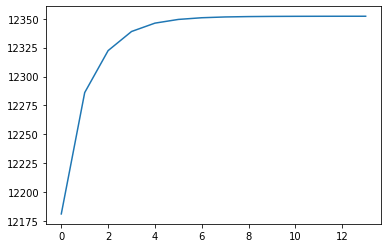

In [ ]:
plt.plot(Q)

In [ ]:
pd.concat([x, calc_distribution(x, theta)], axis=1)

,X,z1,z2,z3,z4,z5,z6
0,25.000141,0.000000,0.000000,0.000000,0.000000,0.000002,0.999998
1,2.996731,0.000000,0.000639,0.999361,0.000000,0.000000,0.000000
2,-0.673019,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.998876,0.000000,0.000610,0.999390,0.000000,0.000000,0.000000
4,25.000178,0.000000,0.000000,0.000000,0.000000,0.000002,0.999998
...,...,...,...,...,...,...,...
13995,3.954072,0.000000,0.999980,0.000000,0.000004,0.000016,0.000000
13996,3.002716,0.000000,0.000632,0.999368,0.000000,0.000000,0.000000
13997,6.085865,0.000000,0.003172,0.000000,0.990131,0.006698,0.000000
13998,2.983889,0.000000,0.002226,0.997774,0.000000,0.000000,0.000000


In [ ]:
np.array(calc_distribution(x, theta)).argmax(axis=1)

array([5, 2, 0, ..., 3, 2, 5])

Зачем всё это нужно?


Допустим, есть признак, который в исходном виде слабо коррелирует с целевой переменной и в модель не даёт требуемого вклада. Вы ничего не знаете про этот признак, не знаете как поделить на категории. Как ем поможет?
1. Строим распределение, пытаемся понять, можно ли его расщепить на какие-то кластеры с распределением, известным вам (экспоненциальное, нормальное, биномиальное, пуассона, геометрическое и т.д.)
2. Запускаем ЕМ-алгоритм для конкретной задачи
3. Берём аргмакс латентных переменных
4. Закидываем полученные категории\кластеры как объясняющие переменные вместо расщеплённой (one-hod encoding)
5. Обучаем заново с категориями

Также как альтернатива кластеризации...

##### (г) Являются ли полученные оценки параметров адекватными (адекватность оцените визуально по гистограмме). Если нет, приведите возможную причину провала EM-алгоритма. 

In [ ]:
clusters = np.array(calc_distribution(x, theta)).argmax(axis=1)
np.bincount(clusters)

array([2000,  991, 4010, 1010,  989, 5000])

In [ ]:
np.unique(clusters)

array([0, 1, 2, 3, 4, 5])

In [ ]:
for i in np.unique(clusters):
  print('Описание кластера', i)
  print(x[clusters==i].describe())

Описание кластера 0
count   2000.000000
mean      -0.007794
std        0.490085
min       -1.900689
25%       -0.334654
50%       -0.004229
75%        0.330225
max        1.785790
Name: X, dtype: float64
Описание кластера 1
count   991.000000
mean      4.016693
std       0.484443
min       2.466506
25%       3.687216
50%       4.029693
75%       4.333080
max       5.395986
Name: X, dtype: float64
Описание кластера 2
count   4010.000000
mean       3.000336
std        0.009972
min        2.963145
25%        2.993415
50%        3.000281
75%        3.007171
max        3.037902
Name: X, dtype: float64
Описание кластера 3
count   1010.000000
mean       8.034356
std        0.830104
min        5.673783
25%        7.442372
50%        8.014889
75%        8.609319
max       10.253214
Name: X, dtype: float64
Описание кластера 4
count   989.000000
mean     16.980821
std       2.909147
min      10.283501
25%      14.979441
50%      17.011301
75%      18.863515
max      26.935204
Name: X, dtype: floa

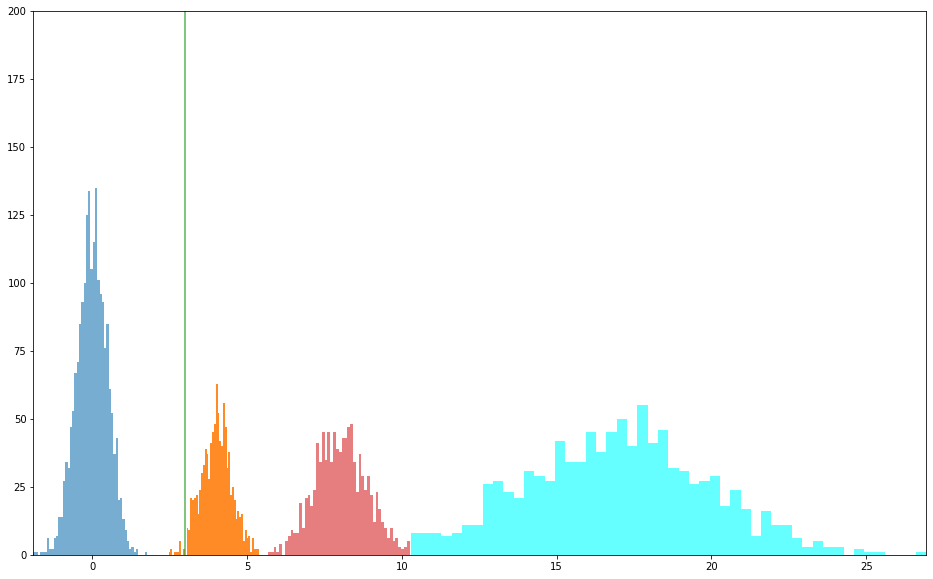

In [ ]:
plt.figure(figsize=(16, 10))
plt.hist(x[clusters==0], alpha = 0.6, bins=50)
plt.hist(x[clusters==1], alpha = 0.9, bins=50)
plt.hist(x[clusters==2], alpha = 0.6, bins=5)
plt.hist(x[clusters==3], alpha = 0.6, bins=50)
plt.hist(x[clusters==4], alpha = 0.6, color='cyan', bins=50)
plt.hist(x[clusters==5], alpha = 0.9, color='black', bins=5)
plt.ylim(0, 200)
plt.xlim(x.min(), x.max())
plt.show()

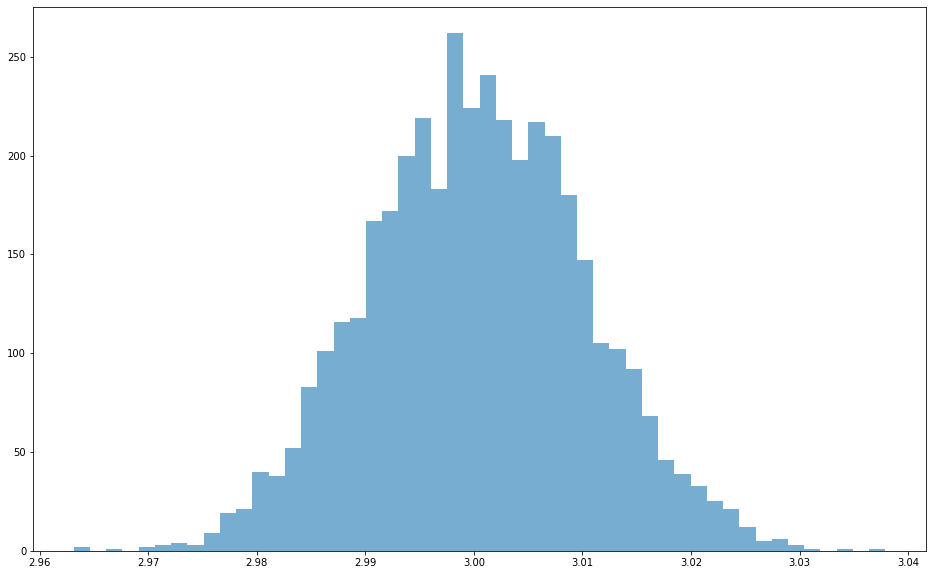

In [ ]:
plt.figure(figsize=(16, 10))
plt.hist(x[clusters==2], alpha = 0.6, bins=50)
plt.show()

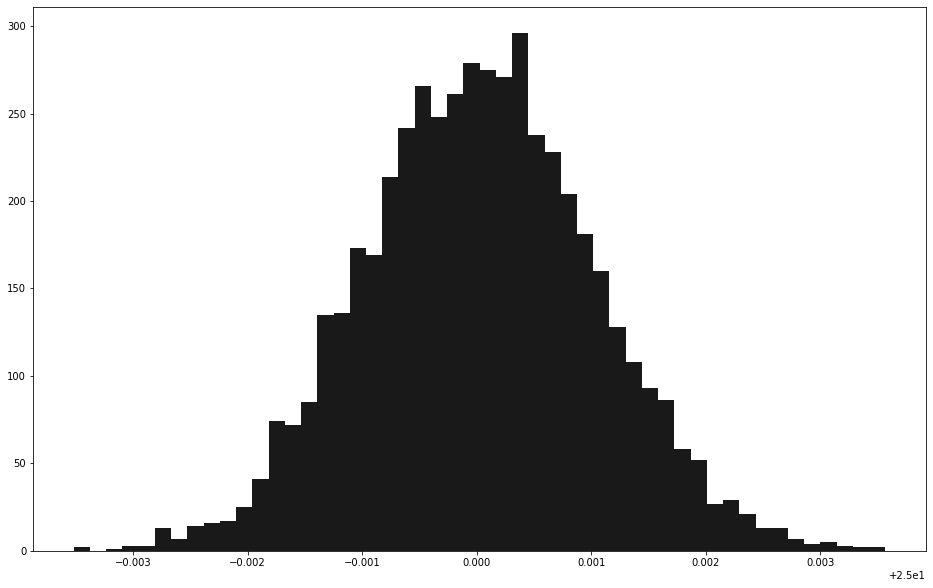

In [ ]:
plt.figure(figsize=(16, 10))
plt.hist(x[clusters==5], alpha = 0.9, color='black', bins=50)
plt.show()

Видим, что в целом 4 прикинутых изначально распределения действительно весьма успешно определились ЕМ-алгоритмом, однако нормальное распределение в окрестности 0 и вырожденное распределение в окрестности 25 куда-то испарились. Возможно, при более детальном подходе к визуализации работы алгоритма получилось бы найти, куда же они спрятались...

#### Задача 15. Из контрольной прошлого года

В контрольной работе прошлого года была такая задача:

> У меня есть три монетки. Они выпадают орлом с вероятностями $p_1$, $p_2$ и $p_3 = 1$. Я провожу эксперимент из 100 раундов. В каждом раунде я равновероятно выбираю одну из монеток, подбрасываю её два раза и записываю число выпавших орлов. После окончания эксперимента у меня на бумажке остаётся 100 записанных чисел. Какая монетка подкидывалась в каждом раунде, я не помню.

На контрольной требовалось описать EM-алгоритм для нахождения $\hat{p}_1$ и $\hat{p}_2$.

**[а]** **(3 балла)** В файле `15.csv` приведена описанная выборка из 100 чисел. Реализуйте EM-алгоритм для нахождения $\hat{p}_1$ и $\hat{p}_2$.

**[б]** Постройте график $Q$ в зависимости от числа итераций.

**[в]** Изучите выборку и прокомментируйте адекватность полученных оценок.

In [ ]:
data15 = pd.read_csv('https://raw.githubusercontent.com/V-Marco/psmo_21_22/main/hw/hw1/15.csv', 
                     usecols=[1])
data15

,X
0,2
1,1
2,2
3,2
4,0
...,...
95,1
96,2
97,2
98,1


In [ ]:
data15.value_counts()

X
2    38
1    32
0    30
dtype: int64

##### (a) Реализуйте EM-алгоритм для нахождения $\hat{p}_1$ и $\hat{p}_2$.

$$ L(X | p_1, p_2) = \prod\limits_{i=1}^{100} (\frac{1}{3}\text{Bin}(2, p_1)+\frac{1}{3}\text{Bin}(2, p_2)+\frac{1}{3}\text{Bin}(2, 1)) $$

In [ ]:
# Задайте плотность x
def f(x, n, p):
    return p**(x)*(1-p)**(x)   

##### (б) Постройте график $Q$ в зависимости от числа итераций.

##### (в) Изучите выборку и прокомментируйте адекватность полученных оценок.